In [1]:
import argparse

import torch
import wandb
wandb.login()

from dataloader import get_dataloaders
from utils import get_model
from train import Trainer
import shlex
import numpy as np
import torch.nn.functional as F

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zeusisgreat (zeusisgreat-indian-institute-of-technology-bombay). Use `wandb login --relogin` to force relogin


In [20]:
import sys
sys.path.append('./AutoAugment/')

import torch
import torchvision
import torchvision.transforms as transforms
from AutoAugment.autoaugment import CIFAR10Policy, SVHNPolicy, ImageNetPolicy


padding = 28
size = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transform_list = [transforms.RandomCrop(size=(size,size), padding=padding)]
train_transform_list.append(ImageNetPolicy())
train_transform_list = [transforms.Resize(size + 4)] + train_transform_list
train_transform = transforms.Compose(
        train_transform_list+[
            transforms.ToTensor(),
            transforms.Normalize(
                mean=mean,
                std = std
            )
        ]
    )

test_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std =std
        )
    ])

In [21]:
train_ds = torchvision.datasets.ImageFolder('../../data/imagenet100/train', transform=train_transform)
test_ds = torchvision.datasets.ImageFolder('../../data/imagenet100/val', transform=test_transform)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

### KAN-Mixer (Skip min = 1.0 and 8.6M params)

In [22]:
from kan_mixer import KANMixer

"""
python main.py --dataset imgnet --model kan_mixer --autoaugment --epochs 600 --eval-batch-size 256 
--num-workers 12 --cutmix-prob 0.5 --patch-size 8 --hidden-c 512 --hidden-s 64 --hidden-size 128  
--batch-size 256 --num-layers 4 --skip-min 1.0 --checkpoint-epoch 0
"""
hidden_size=128
patch_size =8
hidden_c = 512
hidden_s = 64
num_layers = 4
skip_min = 1.0
model_name = 'kan_mixer'
dataset = 'imgnet'
optimizer = 'adam'
scheduler = 'cosine'
lr = 1e-3

model = KANMixer(
    in_channels=3,
    img_size=224,
    hidden_size=hidden_size,
    patch_size =patch_size,
    hidden_c = hidden_c,
    hidden_s = hidden_s,
    num_layers = num_layers,
    num_classes=100,
    drop_p=0,
    off_act=False,
    is_cls_token=False,
    use_poly = False, 
    degree_poly = 2,
    use_base_update = True,
    base_activation = F.silu,
    use_same_fn = False,
    use_same_weight = False,
    use_pe = False,
    use_cpd = False,
    use_softmax_prod = False,
    num_grids = 8,
    skip_min = skip_min,
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

model_config = f"{model_name}_{dataset}_{optimizer}_{scheduler}_{lr}_PS{patch_size}_HSize{hidden_size}_HC{hidden_c}_HS{hidden_s}_NL{num_layers}_SM{skip_min}_PARAMS{num_params}"
print(num_params)

Polynomial Basis: False, Degree of Polynomial: 2, Using Same Function: False, Using same weights: False, Positional Embeddings: False, CPD Decomposition: False, Softmax Prod: False
8688676


In [25]:
PATH = f"../saved_models/{10}, {model_config}.pt"
checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [26]:
activations = {}

def hook_fn(module, input, output):
    activations[module] = output

handles = []
for layer_id in range(num_layers):
    handle1 = model.mixer_layers[layer_id].kan1.fc1.register_forward_hook(hook_fn)
    handle2 = model.mixer_layers[layer_id].kan1.fc2.register_forward_hook(hook_fn)
    handle3 = model.mixer_layers[layer_id].kan2.fc1.register_forward_hook(hook_fn)
    handle4 = model.mixer_layers[layer_id].kan2.fc2.register_forward_hook(hook_fn)
    handles.append([handle1,handle2, handle3, handle4 ])

In [27]:
import torch.nn as nn
from tqdm import tqdm

act_per_batch = []

for i, batch in tqdm(enumerate(test_dl)):
    if i == 10:
        break

    img, label = batch
    out = model(img)
    if i <= 10:
        acts = []
        for layer_id in range(num_layers):
            act1 = activations[model.mixer_layers[layer_id].kan1.fc1].detach().numpy()
            act2 = activations[model.mixer_layers[layer_id].kan1.fc2].detach().numpy()
            act3 = activations[model.mixer_layers[layer_id].kan2.fc1].detach().numpy()
            act4 = activations[model.mixer_layers[layer_id].kan2.fc2].detach().numpy()
            acts.append([act1, act2, act3, act4])
    
        act_per_batch.append(acts)

    else:
        for layer_id in range(num_layers):
            act1 = activations[model.mixer_layers[layer_id].kan1.fc1].detach().numpy()
            act2 = activations[model.mixer_layers[layer_id].kan1.fc2].detach().numpy()
            act3 = activations[model.mixer_layers[layer_id].kan2.fc1].detach().numpy()
            act4 = activations[model.mixer_layers[layer_id].kan2.fc2].detach().numpy()
            act_per_batch[0][layer_id][0] = np.concatenate((act_per_batch[0][layer_id][0], act1), axis=0)
            act_per_batch[0][layer_id][1] = np.concatenate((act_per_batch[0][layer_id][1], act2), axis=0)
            act_per_batch[0][layer_id][2] = np.concatenate((act_per_batch[0][layer_id][2], act3), axis=0)
            act_per_batch[0][layer_id][3] = np.concatenate((act_per_batch[0][layer_id][3], act4), axis=0)

10it [02:58, 17.82s/it]


In [28]:
final_act = []
for layer_id in tqdm(range(num_layers)):
    final_act.append([])
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][0] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][1] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][2] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][3] for i in range(10)], axis=0))

100%|█████████████████████████████████████████████| 4/4 [00:20<00:00,  5.21s/it]


In [9]:
from torch.linalg import matrix_rank

means_fc1 = []
std_fc1 = []

means_fc2 = []
std_fc2 = []

means_fc3 = []
std_fc3 = []

means_fc4 = []
std_fc4 = []

for layer_id in range(num_layers):
    print(f'Layer {layer_id}, Batch Size: {final_act[layer_id][0].shape[0]}')
    m1 = matrix_rank(torch.tensor(final_act[layer_id][0])).float()
    print('m1 done')
    m2 = matrix_rank(torch.tensor(final_act[layer_id][1])).float()
    print('m2 done')
    m3 = matrix_rank(torch.tensor(final_act[layer_id][2])).float()
    print('m3 done')
    m4 = matrix_rank(torch.tensor(final_act[layer_id][3])).float()
    print('m4 done')

    means_fc1.append(m1.mean().item())
    means_fc2.append(m2.mean().item())
    means_fc3.append(m3.mean().item())
    means_fc4.append(m4.mean().item())
    std_fc1.append(m1.std().item())
    std_fc2.append(m2.std().item())
    std_fc3.append(m3.std().item())
    std_fc4.append(m4.std().item())
    
    
    print(m1.mean(), m1.std())
    print(m2.mean(), m2.std())
    print(m3.mean(), m3.std())
    print(m4.mean(), m4.std())
    print('-'*20)

Layer 0, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(42.4879) tensor(1.0168)
tensor(77.6895) tensor(7.9699)
tensor(248.4328) tensor(4.5278)
tensor(128.) tensor(0.)
--------------------
Layer 1, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(64.) tensor(0.)
tensor(48.0012) tensor(0.0342)
tensor(129.) tensor(0.)
tensor(128.) tensor(0.)
--------------------
Layer 2, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(64.) tensor(0.)
tensor(48.2457) tensor(0.4527)
tensor(129.) tensor(0.)
tensor(128.) tensor(0.)
--------------------
Layer 3, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(60.2047) tensor(0.6991)
tensor(16.) tensor(0.)
tensor(129.) tensor(0.)
tensor(128.) tensor(0.)
--------------------


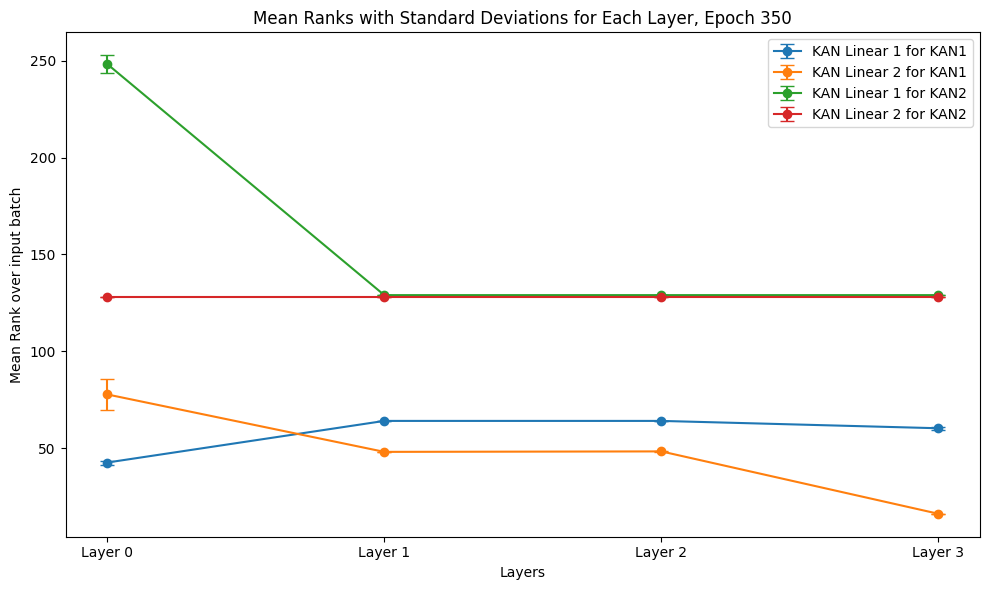

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the means and standard deviations
layers = ["Layer 0", "Layer 1", "Layer 2", "Layer 3"]
x = np.arange(len(layers))

# Plotting the line plots with standard deviations as error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x, means_fc1, yerr=std_fc1, label="KAN Linear 1 for KAN1", fmt='-o', capsize=5)
plt.errorbar(x, means_fc2, yerr=std_fc2, label="KAN Linear 2 for KAN1", fmt='-o', capsize=5)
plt.errorbar(x, means_fc3, yerr=std_fc3, label="KAN Linear 1 for KAN2", fmt='-o', capsize=5)
plt.errorbar(x, means_fc4, yerr=std_fc4, label="KAN Linear 2 for KAN2", fmt='-o', capsize=5)

# Adding labels and titles
plt.xticks(x, layers)
plt.xlabel("Layers")
plt.ylabel("Mean Rank over input batch")
plt.title("Mean Ranks with Standard Deviations for Each Layer, Epoch 10")
plt.legend()

# Display the plot
plt.tight_layout()
plt.savefig('Epoch 10, Skip min 1.0, 8.6M params.jpeg',bbox_inches = 'tight', dpi = 200)
plt.show()

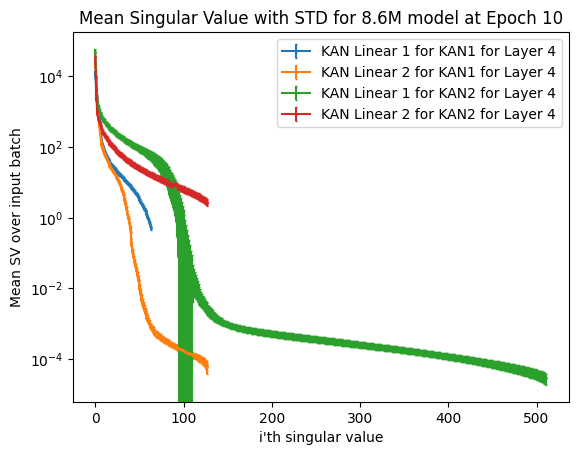

In [29]:
from torch.linalg import svdvals
svd_30 = svdvals(torch.tensor(final_act[3][0]))
svd_31 = svdvals(torch.tensor(final_act[3][1]))
svd_32 = svdvals(torch.tensor(final_act[3][2]))
svd_33 = svdvals(torch.tensor(final_act[3][3]))

plt.errorbar([i for i in range(svd_30.shape[-1])], svd_30.mean(axis = 0), yerr=svd_30.std(axis = 0) , label='KAN Linear 1 for KAN1 for Layer 4', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_31.shape[-1])], svd_31.mean(axis = 0), yerr=svd_31.std(axis = 0) , label='KAN Linear 2 for KAN1 for Layer 4', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_32.shape[-1])], svd_32.mean(axis = 0), yerr=svd_32.std(axis = 0) , label='KAN Linear 1 for KAN2 for Layer 4', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_33.shape[-1])], svd_33.mean(axis = 0), yerr=svd_33.std(axis = 0) , label='KAN Linear 2 for KAN2 for Layer 4', marker='o', capsize=1, ms = 1)
plt.title('Mean Singular Value with STD for 8.6M model at Epoch 10')
plt.xlabel("i'th singular value")
plt.ylabel('Mean SV over input batch')
plt.yscale('log')
plt.legend()
plt.savefig('Epoch 10, SV for Layer 3, 8.6M.jpg', dpi = 200, bbox_inches = 'tight')
plt.show()

In [20]:
torch.tensor(acts[layer_id][0])

tensor([[[-8.3177e+00, -4.2331e+00, -4.2302e+00,  ..., -5.3003e-02,
          -6.1244e-01, -2.2536e+00],
         [-1.3872e+01, -7.1148e+00, -7.1066e+00,  ..., -6.3920e+00,
          -4.2239e+00, -3.2671e+00],
         [-1.4803e+01, -6.9527e+00, -6.9440e+00,  ..., -5.1088e+00,
          -5.0535e+00, -4.0835e+00],
         ...,
         [-1.4479e+01, -6.4751e+00, -6.4671e+00,  ...,  2.0095e+00,
          -4.8282e+00, -8.0902e+00],
         [-8.9278e+00, -5.8281e+00, -5.8222e+00,  ..., -5.0638e+00,
          -3.9441e+00, -2.8392e+00],
         [-1.7186e+01, -7.5486e+00, -7.5391e+00,  ..., -4.9465e+00,
          -5.2418e+00, -3.9916e+00]],

        [[-6.6479e+00, -5.4130e+00, -5.4065e+00,  ..., -3.9082e+00,
          -5.1781e+00, -5.6176e+00],
         [-1.5470e+01, -7.0443e+00, -7.0363e+00,  ..., -6.9333e+00,
          -4.2517e+00, -2.3368e+00],
         [-1.4288e+01, -6.9458e+00, -6.9371e+00,  ..., -5.6445e+00,
          -4.7878e+00, -4.6636e+00],
         ...,
         [-1.2479e+01, -7

### KAN-Mixer (Skip min = 1.0 and 18.6M params)

In [3]:
from kan_mixer import KANMixer

"""
python main.py --dataset imgnet --model kan_mixer --autoaugment --epochs 600 --eval-batch-size 256 
--num-workers 12 --cutmix-prob 0.5 --patch-size 16 --hidden-c 640 --hidden-s 80 --hidden-size 160  
--batch-size 256 --num-layers 8 --skip-min 1.0 --checkpoint-epoch 360

"""
hidden_size=160
patch_size = 16
hidden_c = 640
hidden_s = 80
num_layers = 8
skip_min = 1.0
model_name = 'kan_mixer'
dataset = 'imgnet'
optimizer = 'adam'
scheduler = 'cosine'
lr = 1e-3

model = KANMixer(
    in_channels=3,
    img_size=224,
    hidden_size=hidden_size,
    patch_size =patch_size,
    hidden_c = hidden_c,
    hidden_s = hidden_s,
    num_layers = num_layers,
    num_classes=100,
    drop_p=0,
    off_act=False,
    is_cls_token=False,
    use_poly = False, 
    degree_poly = 2,
    use_base_update = True,
    base_activation = F.silu,
    use_same_fn = False,
    use_same_weight = False,
    use_pe = False,
    use_cpd = False,
    use_softmax_prod = False,
    num_grids = 8,
    skip_min = skip_min,
)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

model_config = f"{model_name}_{dataset}_{optimizer}_{scheduler}_{lr}_PS{patch_size}_HSize{hidden_size}_HC{hidden_c}_HS{hidden_s}_NL{num_layers}_SM{skip_min}_PARAMS{num_params}"
print(num_params)

Polynomial Basis: False, Degree of Polynomial: 2, Using Same Function: False, Using same weights: False, Positional Embeddings: False, CPD Decomposition: False, Softmax Prod: False
18286820


In [7]:
PATH = f"../saved_models/{600}, {model_config}.pt"
checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
activations = {}

def hook_fn(module, input, output):
    activations[module] = output

handles = []
for layer_id in range(num_layers):
    handle1 = model.mixer_layers[layer_id].kan1.fc1.register_forward_hook(hook_fn)
    handle2 = model.mixer_layers[layer_id].kan1.fc2.register_forward_hook(hook_fn)
    handle3 = model.mixer_layers[layer_id].kan2.fc1.register_forward_hook(hook_fn)
    handle4 = model.mixer_layers[layer_id].kan2.fc2.register_forward_hook(hook_fn)
    handles.append([handle1,handle2, handle3, handle4 ])

In [9]:
import torch.nn as nn
from tqdm import tqdm

act_per_batch = []

for i, batch in tqdm(enumerate(test_dl)):
    if i == 10:
        break

    img, label = batch
    out = model(img)
    acts = []
    for layer_id in range(num_layers):
        act1 = activations[model.mixer_layers[layer_id].kan1.fc1].detach().numpy()
        act2 = activations[model.mixer_layers[layer_id].kan1.fc2].detach().numpy()
        act3 = activations[model.mixer_layers[layer_id].kan2.fc1].detach().numpy()
        act4 = activations[model.mixer_layers[layer_id].kan2.fc2].detach().numpy()
        acts.append([act1, act2, act3, act4])

    act_per_batch.append(acts)

10it [02:00, 12.07s/it]


In [10]:
final_act = []
for layer_id in tqdm(range(num_layers)):
    final_act.append([])
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][0] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][1] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][2] for i in range(10)], axis=0))
    final_act[-1].append(np.concatenate([act_per_batch[i][layer_id][3] for i in range(10)], axis=0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:35<00:00, 19.45s/it]


In [11]:
from torch.linalg import matrix_rank

for layer_id in range(num_layers):
    print(f'Layer {layer_id}, Batch Size: {final_act[layer_id][0].shape[0]}')
    m1 = matrix_rank(torch.tensor(final_act[layer_id][0])).float()
    print('m1 done')
    m2 = matrix_rank(torch.tensor(final_act[layer_id][1])).float()
    print('m2 done')
    m3 = matrix_rank(torch.tensor(final_act[layer_id][2])).float()
    print('m3 done')
    m4 = matrix_rank(torch.tensor(final_act[layer_id][3])).float()
    print('m4 done')
    
    print(m1.mean(), m1.std())
    print(m2.mean(), m2.std())
    print(m3.mean(), m3.std())
    print(m4.mean(), m4.std())
    print('-'*20)

Layer 0, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(23.6535) tensor(1.6286)
tensor(31.9926) tensor(1.8918)
tensor(174.6484) tensor(22.4456)
tensor(157.4039) tensor(7.4183)
--------------------
Layer 1, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(74.) tensor(1.1913)
tensor(64.6641) tensor(3.1262)
tensor(148.2207) tensor(1.5982)
tensor(159.9828) tensor(0.2177)
--------------------
Layer 2, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(66.9992) tensor(0.0279)
tensor(64.4594) tensor(1.3196)
tensor(146.2258) tensor(0.9032)
tensor(159.5234) tensor(2.7210)
--------------------
Layer 3, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(80.) tensor(0.)
tensor(81.) tensor(0.)
tensor(148.2156) tensor(1.1823)
tensor(159.9758) tensor(0.3392)
--------------------
Layer 4, Batch Size: 2560
m1 done
m2 done
m3 done
m4 done
tensor(79.9867) tensor(0.1145)
tensor(79.7637) tensor(0.4249)
tensor(155.7035) tensor(0.8832)
tensor(160.) tensor(0.)
--------------------
La

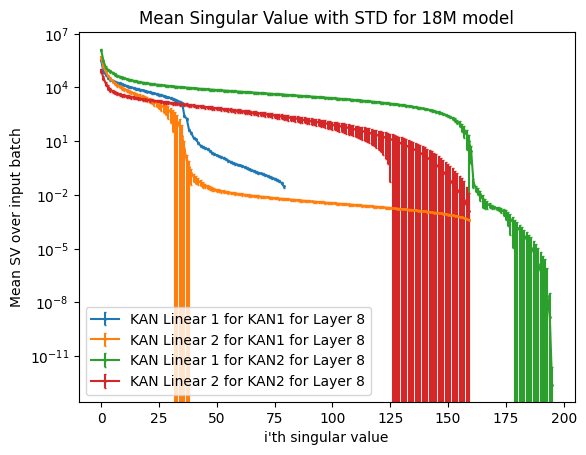

In [76]:
from torch.linalg import svdvals
svd_70 = svdvals(torch.tensor(final_act[7][0]))
svd_71 = svdvals(torch.tensor(final_act[7][1]))
svd_72 = svdvals(torch.tensor(final_act[7][2]))
svd_73 = svdvals(torch.tensor(final_act[7][3]))

plt.errorbar([i for i in range(svd_70.shape[-1])], svd_70.mean(axis = 0), yerr=svd_70.std(axis = 0) , label='KAN Linear 1 for KAN1 for Layer 8', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_71.shape[-1])], svd_71.mean(axis = 0), yerr=svd_71.std(axis = 0) , label='KAN Linear 2 for KAN1 for Layer 8', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_72.shape[-1])], svd_72.mean(axis = 0), yerr=svd_72.std(axis = 0) , label='KAN Linear 1 for KAN2 for Layer 8', marker='o', capsize=1, ms = 1)
plt.errorbar([i for i in range(svd_73.shape[-1])], svd_73.mean(axis = 0), yerr=svd_73.std(axis = 0) , label='KAN Linear 2 for KAN2 for Layer 8', marker='o', capsize=1, ms = 1)
plt.title('Mean Singular Value with STD for 18M model')
plt.xlabel("i'th singular value")
plt.ylabel('Mean SV over input batch')
plt.yscale('log')
plt.legend()
plt.savefig('SV for Layer 7.jpg', dpi = 200, bbox_inches = 'tight')
plt.show()

In [34]:
layers = ['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6', 'Layer 7']

# Means and standard deviations for each m
after_kan1_m1_mean = [23.6535, 74.0, 66.9992, 80.0, 79.9867, 79.0320, 57.3250, 43.1074]
after_kan1_m1_std = [1.6286, 1.1913, 0.0279, 0.0, 0.1145, 0.1761, 0.9748, 0.3409]

after_kan1_m2_mean = [31.9926, 64.6641, 64.4594, 81.0, 79.7637, 79.4176, 42.6402, 34.4953]
after_kan1_m2_std = [1.8918, 3.1262, 1.3196, 0.0, 0.4249, 0.5180, 1.2243, 1.8221]

after_kan2_m1_mean = [174.6484, 148.2207, 146.2258, 148.2156, 155.7035, 159.9988, 160.0, 155.5356]
after_kan2_m1_std = [22.4456, 1.5982, 0.9032, 1.1823, 0.8832, 0.1101, 0.0, 1.1585]

after_kan2_m2_mean = [157.4039, 159.9828, 159.5234, 159.9758, 160.0, 160.0, 160.0, 131.5934]
after_kan2_m2_std = [7.4183, 0.2177, 2.7210, 0.3392, 0.0, 0.0, 0.0, 10.9321]


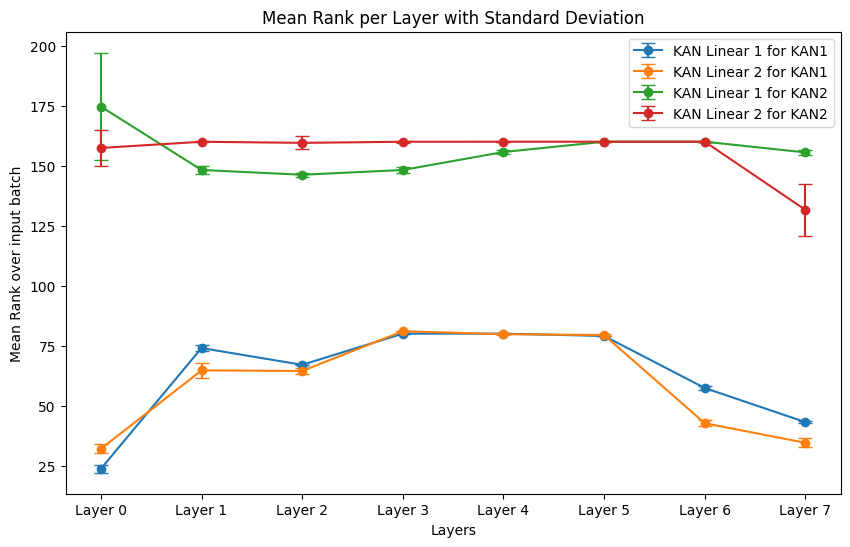

In [35]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot each set of means with their std deviations
plt.errorbar(layers, after_kan1_m1_mean, yerr=after_kan1_m1_std, label='KAN Linear 1 for KAN1', marker='o', capsize=5)
plt.errorbar(layers, after_kan1_m2_mean, yerr=after_kan1_m2_std, label='KAN Linear 2 for KAN1', marker='o', capsize=5)
plt.errorbar(layers, after_kan2_m1_mean, yerr=after_kan2_m1_std, label='KAN Linear 1 for KAN2', marker='o', capsize=5)
plt.errorbar(layers, after_kan2_m2_mean, yerr=after_kan2_m2_std, label='KAN Linear 2 for KAN2', marker='o', capsize=5)

# Customize the plot
plt.title('Mean Rank per Layer with Standard Deviation')
plt.xlabel('Layers')
plt.ylabel('Mean Rank over input batch')
plt.legend()
#plt.grid(True)
plt.savefig('Skip min 1.0, 18.3M params.jpeg',bbox_inches = 'tight', dpi = 200)
# Show the plot
plt.show()
